# Import the necessary packages

In [1]:
import os
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprosessing

In [3]:
# initialization for initial learning rate, number of epochs and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# initialize directory to dataset, dataset in this folder contains 4800
DIRECTORY = "/content/drive/MyDrive/Fake-person-dataset2/"
CATEGORIES = ["with_mask", "without_mask"]

# initalize the list the data and class of the images
# append to corresponding array grab the list of images in our dataset directory, then initialize the list of data and class 
print("[INFO] Loading Images...")

dataset = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	dataset.append(image)
    	labels.append(category)

# perform one-hot encoding with the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

dataset = np.array(dataset, dtype="float32")
labels = np.array(labels)

# repeat the pre-processing for real-person-testset
# real-person data contains 1200 dataset in this folder and will be used as testset
REALDIR = "/content/drive/MyDrive/Fake-person-realtestset2/"
REALCATE = ["with_mask", "without_mask"]

print("[INFO] Loading Real-person Images...")

realdataset = []
reallabels = []

for realcate in REALCATE:
    newpath = os.path.join(REALDIR, realcate)
    for realimg in os.listdir(newpath):
    	realimg_path = os.path.join(newpath, realimg)
    	images = load_img(realimg_path, target_size=(224, 224))
    	images = img_to_array(images)
    	images = preprocess_input(images)

    	realdataset.append(images)
    	reallabels.append(realcate)
     
reallabels = lb.fit_transform(reallabels)
reallabels = to_categorical(reallabels)

realdataset = np.array(realdataset, dtype="float32")
reallabels = np.array(reallabels)

[INFO] Loading Images...
[INFO] Loading Real-person Images...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


# Model Training

In [4]:
# split training set and validation dataset
(trainX, validationX, trainY, validationY) = train_test_split(dataset, labels, test_size=0.20, stratify=labels, random_state=42)

# configure image data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network but do not include the head of fully connected layer
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# define the top model for each layer
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# combine head fully connected model on top of the base model 
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze the base model so it will NOT update during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile model
print("[INFO] Compiling Model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] Training Head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(validationX, validationY),
	validation_steps=len(validationX) // BS,
	epochs=EPOCHS)


[INFO] Compiling Model...
[INFO] Training Head...
Epoch 1/20
120/120 [==============================] - 74s 332ms/step - loss: 0.2939 - accuracy: 0.9096 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 2/20
120/120 [==============================] - 39s 322ms/step - loss: 0.0218 - accuracy: 0.9989 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 3/20
120/120 [==============================] - 39s 322ms/step - loss: 0.0098 - accuracy: 0.9995 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 4/20
120/120 [==============================] - 39s 323ms/step - loss: 0.0050 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/20
120/120 [==============================] - 39s 323ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 7.8758e-04 - val_accuracy: 1.0000
Epoch 6/20
120/120 [==============================] - 39s 323ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 5.3449e-04 - val_accuracy: 1.0000
Epoch 7/20
120/120 [==============================] - 39s 324ms/step - l

# Model Prediction and Report

[INFO] Evaluating Network...
              precision    recall  f1-score   support

   with_mask       0.96      0.94      0.95       600
without_mask       0.94      0.96      0.95       600

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200

[INFO] Accuracy...
0.9483333333333334
[INFO] Saving Model...


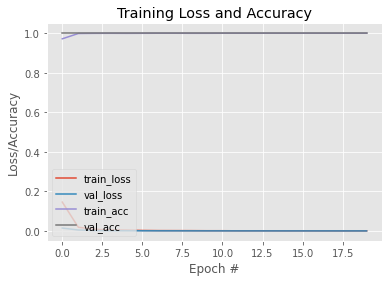

In [6]:
# make predictions on the (REAL-PERSON) testing set
print("[INFO] Evaluating Network...")
predIdxs = model.predict(realdataset, batch_size=BS)

# find the index of label for each of our image in testing set corresponding to its largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# output classification report
print(classification_report(reallabels.argmax(axis=1), predIdxs, target_names=lb.classes_))

# inspect the accuracy of the model on testing set
print("[INFO] Accuracy...")
print(accuracy_score(reallabels.argmax(axis=1), predIdxs))

# finalize the model and save
print("[INFO] Saving Model...")
model.save("/content/drive/MyDrive/Fake-person-dataset2-model/Fake-person-dataset2-model.model", save_format="h5")

# plot grpah to inspect the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/drive/MyDrive/Fake-person-dataset2-model/Fake-person-dataset2-plot.png")
